# Sales Analysis
##### By Philip Padovani

In [1]:
#Step 1 - Import the numpy and pandas libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest

In [32]:
#Step 2 - Import the .xlsx and convert it to a dataframe
salesfile = 'sales.xlsx'
df = pd.read_excel(salesfile)

#Step 2.1 - Count the number of null values an non-null in each column
null_values = df.isna().sum()
not_null_values = df.notna().sum()

#Step 2.3 - See what we're working with
print("Null Values:")
print(null_values)

print("\nNot Null Values:")
print(not_null_values)

Null Values:
Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64

Not Null Values:
Date     7560
Time     7560
State    7560
Group    7560
Unit     7560
Sales    7560
dtype: int64


### How We Would Handle Null Values
- Reviewing the data, this is primarily a set of timeseries data (dates as well as morning, afternoon, evening) as well as other classification units such as "State" and "Group". 
- <b> <i>DataFrame.fillna(value=DataFrame, *, method='bfill', axis=1, inplace=False, limit=5, downcast=_NoDefault.no_default) </b> </i>

In [33]:
#Step 3.1 - Set the "Date" features as a datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

#Step 3.2 - Convert the dates to a normalized format
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')

### Removing Outliers
With the sheer number of entries in the spreadsheet, we cannot disregard the possibility that there are errors and outliers in the data that may negatively impact the validity of the information that we would derive from analysis. For this, we will use the Z-Test to find values outside of the norm.

In [34]:
#Step 4.1 - Identifying Mean, Median, and Standard Deviation for price groupings
from scipy import stats
df[np.abs(stats.zscore(df['Sales']))<=3].groupby('Group').agg(mean_price=('Sales', 'mean'),
                       median_price=('Sales','median'),
                       std_price=('Sales','std'))

,mean_price,median_price,std_price
Group,,,
Kids,43979.700855,35000.0,30219.013739
Men,44168.004280,35000.0,30272.064410
Seniors,42883.789587,32500.0,29596.853427
Women,43909.261242,35000.0,30691.319306


In [35]:
#Step 4.2 - Removing the rows where there may be outliers (Z-Score of 'Sales' is <=3)
from scipy import stats
df = df[np.abs(stats.zscore(df['Sales']))<=3]

### Grouping the Data By State
- After reviewing the data, I've determined the best way to examine the data is to group it by what I feel is the primary/highest level grouping feature; State
- From there, I would understand the performance of those states. This would include the following:
- 1. Mean (average)
  2. Median (Middle/Center Value)
  3. Mode (Most frequently occuring value)
  4. Total Sales

In [36]:
#Step 5.1 - Validate the results
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7472 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    7472 non-null   object
 1   Time    7472 non-null   object
 2   State   7472 non-null   object
 3   Group   7472 non-null   object
 4   Unit    7472 non-null   int64 
 5   Sales   7472 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 408.6+ KB


In [37]:
#Step 5.2 - Group the states, use their Sales as what will be used for the calculations
groupState = df.groupby('State')['Sales']

#Step 5.3 - Calculating and printing the Information
groupStateSummary = groupState.agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None, 'std', 'sum'])
groupStateSummary.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Total Sales']

In [38]:
#step 5.4 - Display the list, sort by total sales
print(groupStateSummary.sort_values(by='Total Sales', ascending=False))

               Mean   Median    Mode  Standard Deviation  Total Sales
State                                                                
 VIC   92799.899194  92500.0  102500        21618.528557     92057500
 NSW   69416.666667  70000.0   75000        20626.651646     74970000
 SA    54497.685185  52500.0   62500        17460.965183     58857500
 QLD   30942.129630  30000.0   22500        13344.638002     33417500
 TAS   21074.074074  20000.0   25000         9024.684205     22760000
 NT    20907.407407  20000.0   22500         8961.907893     22580000
 WA    20511.574074  20000.0   15000         9231.905897     22152500


In [61]:
#Step 5.5 - Group the states, use their Units as what will be used for the calculations
groupUState = df.groupby('State')['Unit']

#Step 5.6 - Calculating and printing the Information
groupUStateSummary = groupUState.agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None, 'std', 'sum'])
groupUStateSummary.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Total Units']

In [62]:
#step 5.7 - Display the list, sort by total sales
print(groupUStateSummary.sort_values(by='Total Units', ascending=False))

            Mean  Median  Mode  Standard Deviation  Total Units
State                                                          
 VIC   37.119960    37.0    41            8.647411        36823
 NSW   27.766667    28.0    30            8.250661        29988
 SA    21.799074    21.0    25            6.984386        23543
 QLD   12.376852    12.0     9            5.337855        13367
 TAS    8.429630     8.0    10            3.609874         9104
 NT     8.362963     8.0     9            3.584763         9032
 WA     8.204630     8.0     6            3.692762         8861


#### So What Do We Know About Sales By State?
So what can we derive from this information?
1. VIC is clearly the highest selling state with a total of 10,565,000 in sales, 30,595,000 more than the #2 top selling state, NSW. Note that there can be numerous factors that cannot be described by the data (such as size of the state, number of locations, density of the states population, etc.)
2. The Standard Deviations describe the volatility on the sales based on the mean (the deviation from the mean). The highest standard deviation is also VIC, meaning that there may be larger fluctuations in sales based on time of the year
3. The Mode describes the most frequent sales numbers. This can be an additional indicator (not definitive) of how much inventory the sites should hold.

### Grouping the Data by Group
- After reviewing the data, I've determined the next best way to examine the data is to group it by what I feel is the second highest level grouping feature; Group.- We will then perform the same functions that we did previously, only setting the grouping to the "Group" feature.Sales

In [39]:
#Step 6.1 - Group the states, use their Sales as what will be used for the calculations
groupGroup = df.groupby('Group')['Sales']

#Step 6.2 - Calculating and printing the Information
groupGroupSummary = groupGroup.agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None, 'std', 'sum'])
groupGroupSummary.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Total Sales']

In [40]:
print(groupGroupSummary.sort_values(by='Total Sales', ascending=False))

                  Mean   Median   Mode  Standard Deviation  Total Sales
Group                                                                  
 Men      44168.004280  35000.0  15000        30272.064410     82550000
 Kids     43979.700855  35000.0  25000        30219.013739     82330000
 Women    43909.261242  35000.0  22500        30691.319306     82022500
 Seniors  42883.789587  32500.0  22500        29596.853427     79892500


In [63]:
#Step 6.3 - Group the states, use their Units as what will be used for the calculations
groupUGroup = df.groupby('Group')['Unit']

#Step 6.4 - Calculating and printing the Information
groupUGroupSummary = groupUGroup.agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None, 'std', 'sum'])
groupUGroupSummary.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Total Units']

In [65]:
print(groupUGroupSummary.sort_values(by='Total Units', ascending=False))

               Mean  Median  Mode  Standard Deviation  Total Units
Group                                                             
 Men      17.667202    14.0     6           12.108826        33020
 Kids     17.591880    14.0    10           12.087605        32932
 Women    17.563704    14.0     9           12.276528        32809
 Seniors  17.153516    13.0     9           11.838741        31957


#### So What Do We Know About Sales By Group?
So what can we derive from this information?
1. The means are all similar, meaning that the averages of all of the sales by group seem to be pretty similar.
2. The modes (most frequent sales number) seems to be fairly similar (22500 in sales for 3 of the 4 groups).
3. The standard deviations of sales for each grouping are very similar, meaning that the sales for each group have a similar deviation from their means (averages).
4. The total sales are all very similar.

<b>In Short</b> - This information shows us that the groupings are likely not a major factor in sales performance, leaving us one more form of sales analysis; Reviewing the sales quarterly.

### Grouping the Data by Timeframe (Quarterly)
- Pandas has a built in method that can break down times by quarter.
- We will have to pass this grouping into a new feature, with we will define as "Quarter"
- We will then perform the same functions that we did previously, only setting the grouping to the "Quarter" feature.

In [41]:
#Step 7.1 - I had to re-format the "Date" features as I was receiving an error
df['Date'] = pd.to_datetime(df['Date'], format='mixed')


In [42]:
#Step 7.2 - Create a new feature named "Quarter". We base this off of the "Date" feature, but leverage the datetime library to assign it a quarterly number 1-4.
df['Quarter'] = df['Date'].dt.to_period('Q')

In [43]:
#7.3 - Check if the added feature was entered with df.head()
df.head()

,Date,Time,State,Group,Unit,Sales,Quarter
0,2020-01-10,Morning,WA,Kids,8,20000,2020Q1
1,2020-01-10,Morning,WA,Men,8,20000,2020Q1
2,2020-01-10,Morning,WA,Women,4,10000,2020Q1
3,2020-01-10,Morning,WA,Seniors,15,37500,2020Q1
4,2020-01-10,Afternoon,WA,Kids,3,7500,2020Q1


In [44]:
#7.4 - Repeat the same steps we did previously (grouping, mean, median, mode, standard deviation)
quarterGroup = df.groupby('Quarter')['Sales']
quarterGroupSummary = quarterGroup.agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None, 'std', 'sum'])
quarterGroupSummary.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Total Sales']

In [45]:
print(quarterGroupSummary.sort_values(by='Total Sales', ascending=False))

                 Mean   Median   Mode  Standard Deviation  Total Sales
Quarter                                                               
2020Q4   43848.545733  35000.0  25000        30246.483046    229152500
2020Q2   44133.466135  35000.0  22500        30074.504927     33232500
2020Q3   43676.470588  35000.0  20000        30728.323427     32670000
2020Q1   42604.026846  32500.0  25000        29449.147164     31740000


In [69]:
#7.5 - Repeat the same steps we did previously (grouping, mean, median, mode, standard deviation), only based on the Units sold rather than sales
quarterUGroup = df.groupby('Quarter')['Unit']
quarterUGroupSummary = quarterUGroup.agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None, 'std', 'sum'])
quarterUGroupSummary.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Total Units']

In [70]:
print(quarterUGroupSummary.sort_values(by='Total Units', ascending=False))

              Mean  Median  Mode  Standard Deviation  Total Units
Quarter                                                          
2020Q4   17.539418    14.0    10           12.098593        91661
2020Q2   17.653386    14.0     9           12.029802        13293
2020Q3   17.470588    14.0     8           12.291329        13068
2020Q1   17.041611    13.0    10           11.779659        12696


#### So What Do We Know About Sales By Quarter?
- With The Mean, Median, and Modes, and Standard Deviations being fairly similar, one can infer that the individual sales as well as the deviations from the mean (average) sale remain fairly consistent throughout the year
- The total sales from Q4 are 7 times greater than the the second highest grossing quarter (Q3), and 2.36 times greater than Q1-Q3 combined.

<b>In Short</b> - Sales are greatly impacted by the time of year. This is likely because this organization is a franchise of retail stores that are heavily impacted by seasonal shopping (black friday and holiday shopping)

### Visualizing Total Sales
Visualizing data is key, as it can give us greater insights into the information we want to derive from the data. Additionally, creating charts, graphs, and scatterplots can allow us to bridge the gap with senior management and customers and deliver information in a digestible format

#### Total Sales Over Time (Line Graph)

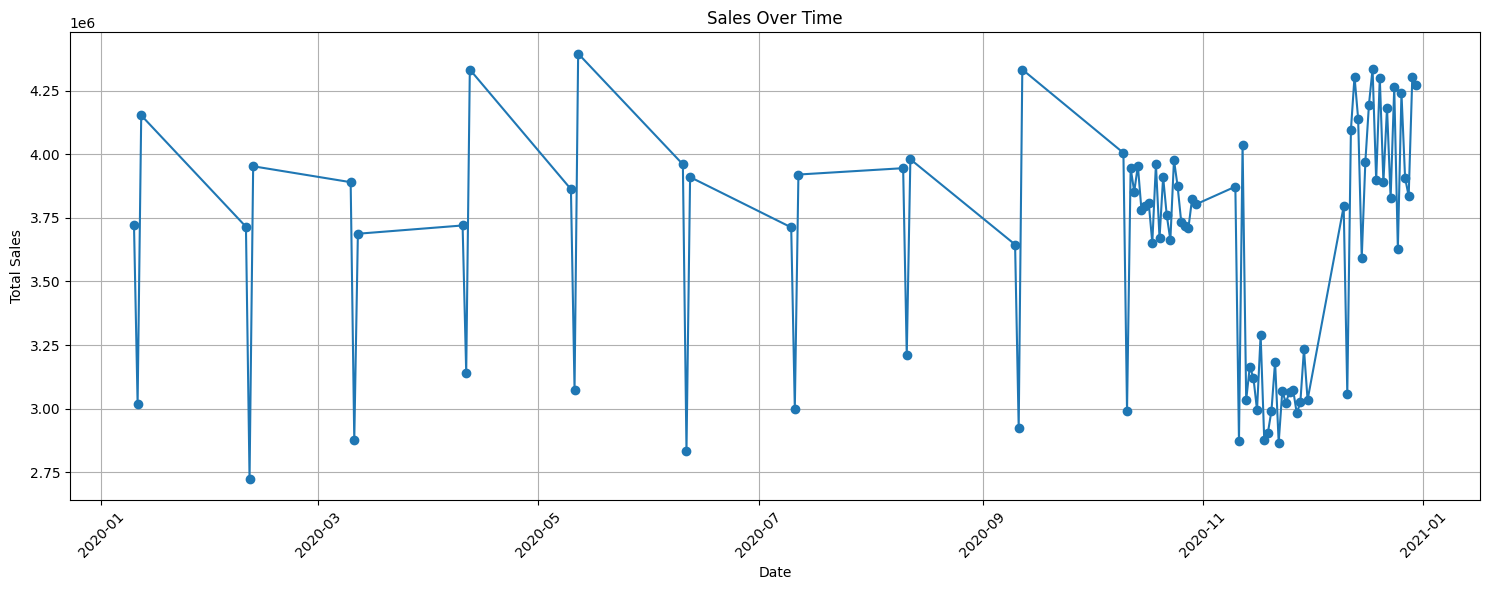

In [46]:
#Lets group the date by sales. I had to call reset_index.
salesByDatePlot = df.groupby('Date')['Sales'].sum().reset_index()

#Configuring the settings for the line chart
plt.figure(figsize=(15, 6))
plt.plot(salesByDatePlot['Date'], salesByDatePlot['Sales'], marker='o', linestyle='-')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Sales Over Time - Total Sales by Day(Seaborn)

Text(0, 0.5, 'Sales (Million)')

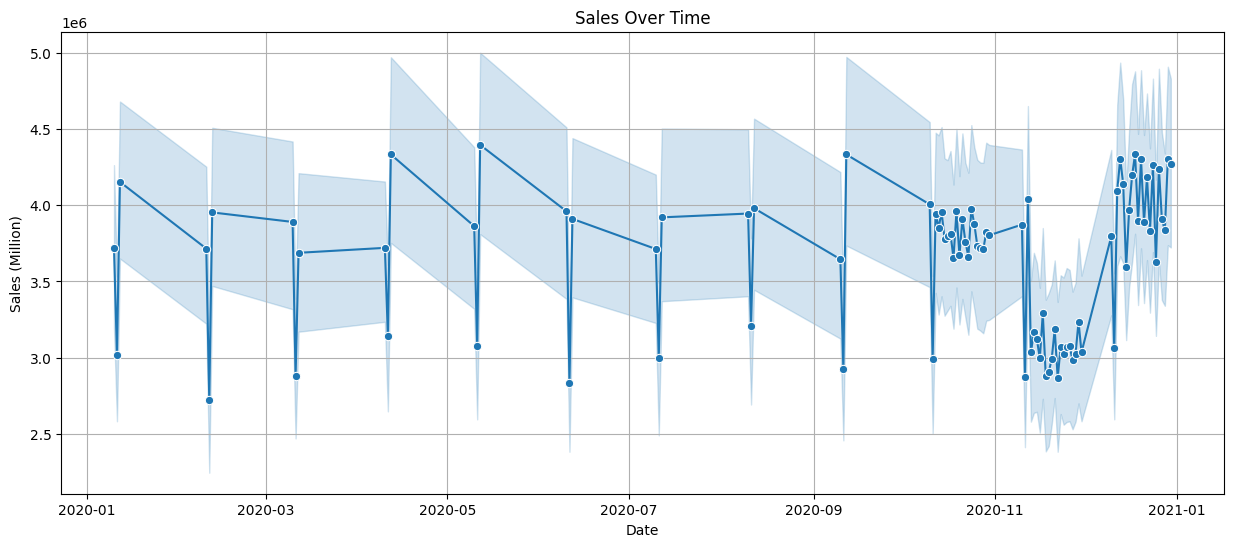

In [47]:
plt.figure(figsize=(15, 6))
plt.grid()
sns.lineplot(x='Date', y='Sales', data=df, marker='o', estimator=sum)
plt.title('Sales Over Time')
plt.ylabel('Sales (Million)')

### Sales Over Time - Mean Sales by Day(Seaborn)

Text(0.5, 1.0, 'Sales Over Time')

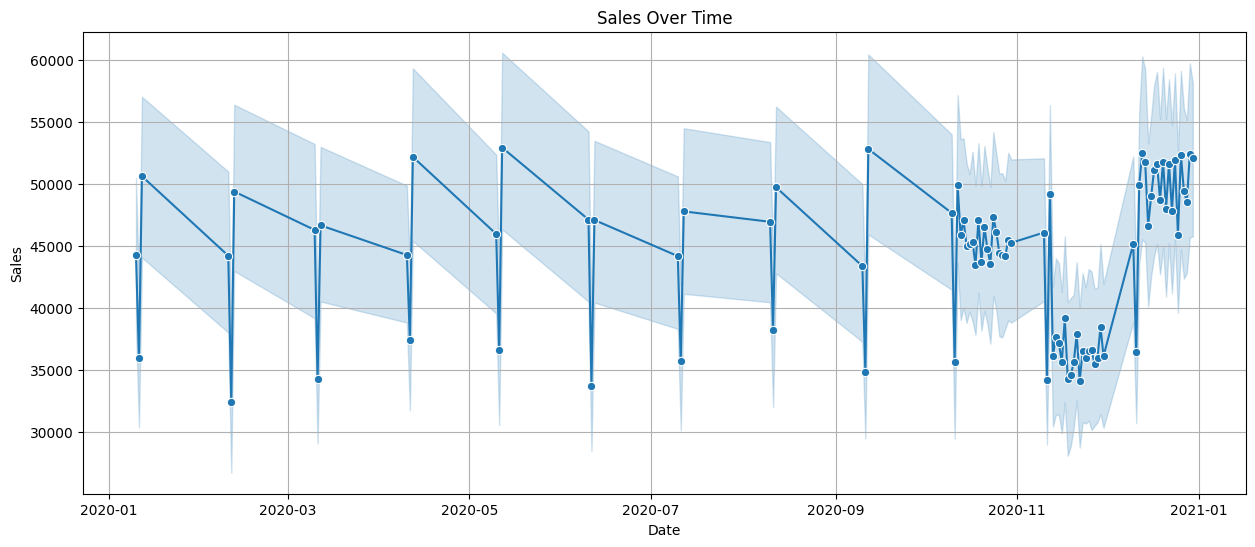

In [48]:
plt.figure(figsize=(15, 6))
plt.grid()
sns.lineplot(x='Date', y='Sales', data=df, marker='o', estimator=np.mean)
plt.title('Sales Over Time')

### Sales Over Time - Mean Sales by Day (grouped by time of day)(Seaborn)

C:\Users\Based King\AppData\Local\Temp\ipykernel_8632\4052232888.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Sales', data=df, marker='o',hue='Time', estimator=np.mean, ci=None)


Text(0.5, 1.0, 'Sales Over Time')

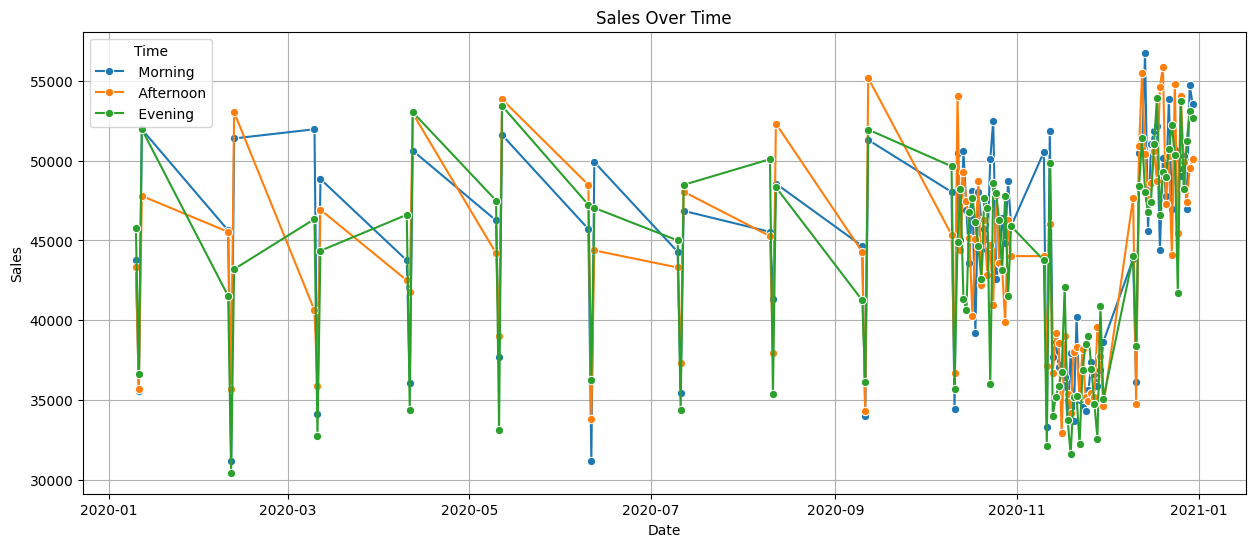

In [49]:
plt.figure(figsize=(15, 6))
plt.grid()
sns.lineplot(x='Date', y='Sales', data=df, marker='o',hue='Time', estimator=np.mean, ci=None)
plt.title('Sales Over Time')

While these are not the most appealing graphs, it does well at visualizing times where sales and transactions are fairly dense. As we can see, this cooberates the information we derived from total sales based on time (quarter)

### Sales by Quarter (Barplot) (Seaborn)

Text(0, 0.5, 'Sales (Million)')

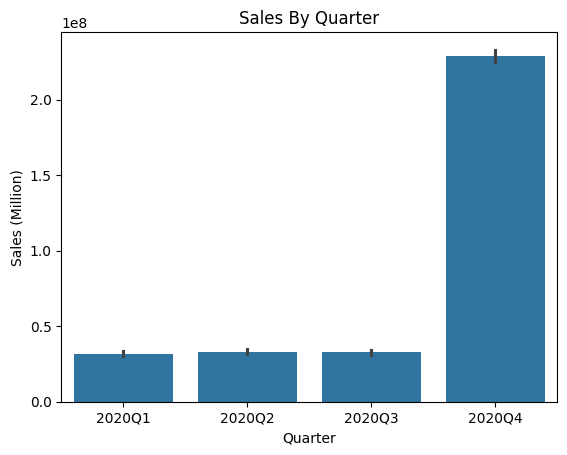

In [50]:
sns.barplot(x='Quarter', y='Sales', data=df, estimator=sum)
plt.title('Sales By Quarter')
plt.ylabel('Sales (Million)')

### Sales By Quarter (Broken Down by Group) - Seaborn

Text(0.5, 1.0, 'Sales By Quarter (Broken Down by Group)')

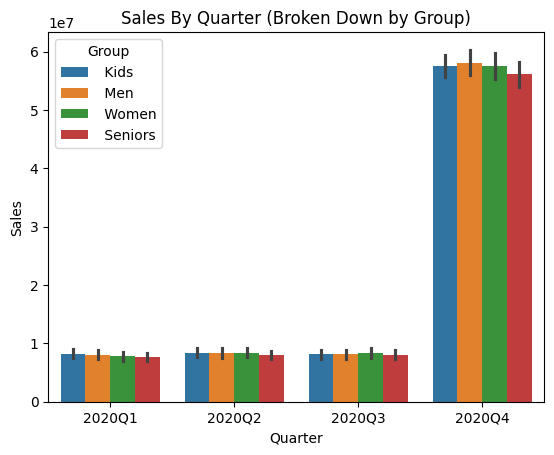

In [51]:
sns.barplot(x='Quarter', y='Sales', hue='Group', data=df, estimator=sum)
plt.title('Sales By Quarter (Broken Down by Group)')

### Sales by Quarter (Broken Down by Time of Day) - Seaborn

Text(0.5, 1.0, 'Sales By Quarter (Broken Down by Time of Day')

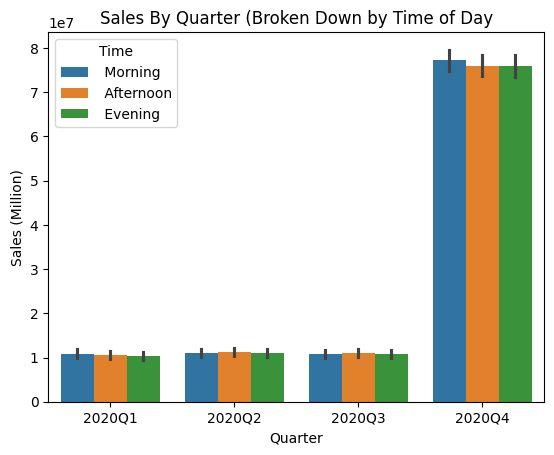

In [52]:
sns.barplot(x='Quarter', y='Sales', hue='Time', data=df, estimator=sum)
plt.ylabel('Sales (Million)')
plt.title('Sales By Quarter (Broken Down by Time of Day')

For this scenario, the use of the barplot is very important to relay quarterly sales data to executives. The barplots above clearly show that Q4 sales are leagues ahead of other quarterly sales for the year. We are also able to show through the hue argument the differentiation between sales by time of day, group, etc.

### Histogram - Distribution of Sales - Seaborn

Text(0.5, 1.0, 'Histogram - Distribution of Sales')

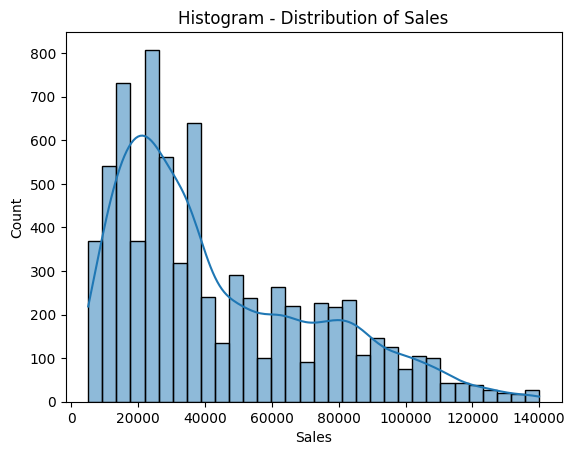

In [53]:
sns.histplot(x='Sales', data=df, kde=True)
plt.title('Histogram - Distribution of Sales')

### Histogram - Distribution of Sales by Group (Stacked) - Seaborn

Text(0.5, 1.0, 'Histogram - Distribution of Sales (By Group, Stacked)')

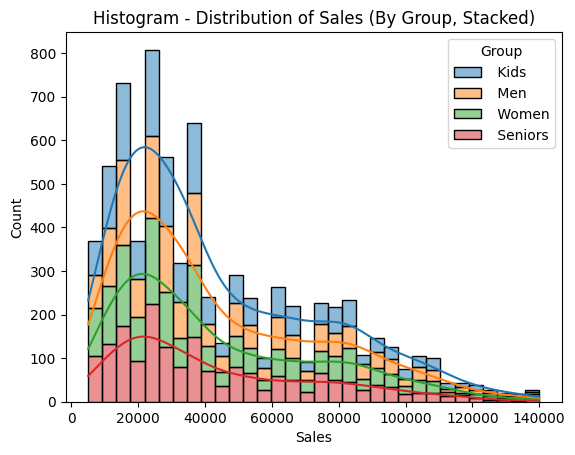

In [54]:
sns.histplot(x='Sales', data=df, kde=True, hue='Group', multiple='stack')
plt.title('Histogram - Distribution of Sales (By Group, Stacked)')

Text(0.5, 1.0, 'Histogram - Distribution of Sales (By Quarter, Stacked)')

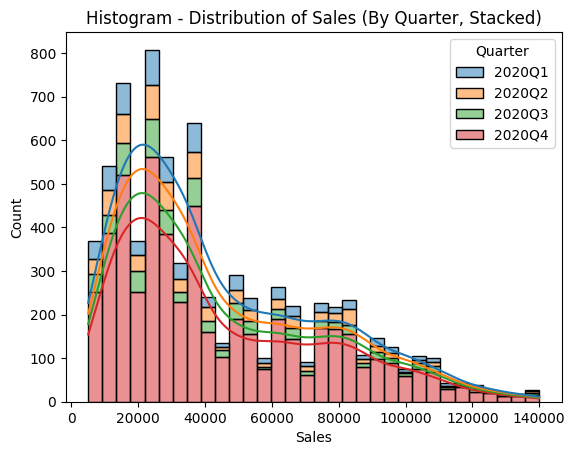

In [55]:
sns.histplot(x='Sales', data=df, kde=True, hue='Quarter', multiple='stack')
plt.title('Histogram - Distribution of Sales (By Quarter, Stacked)')

Using a histogram is key when showing stakeholders the distribution of sales, and how much the average consumer is spending per visit. This can be useful to market towards those consumers targeting those with similar incomes.

Text(0.5, 1.0, 'Box Plot - Sales by Group')

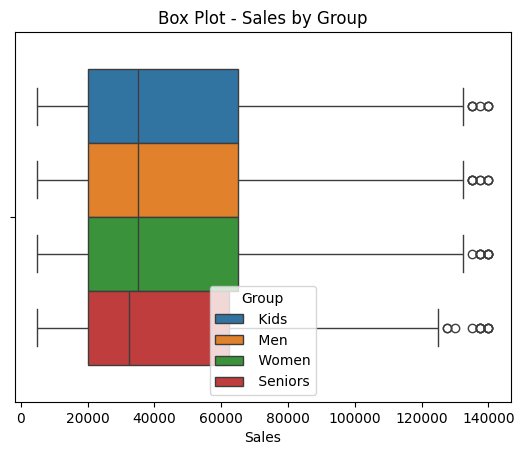

In [57]:
sns.boxplot(x='Sales', data=df, hue='Group')
plt.title('Box Plot - Sales by Group')

Text(0.5, 1.0, 'Box Plot - Sales by Quarter')

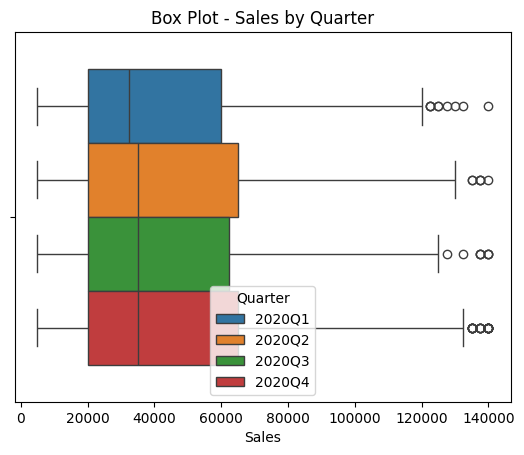

In [58]:
sns.boxplot(x='Sales', data=df, hue='Quarter')
plt.title('Box Plot - Sales by Quarter')

Text(0.5, 1.0, 'Box Plot - Sales by Time of Day')

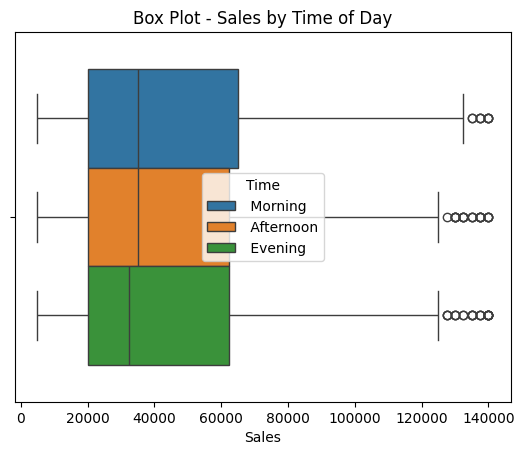

In [71]:
sns.boxplot(x='Sales', data=df, hue='Time')
plt.title('Box Plot - Sales by Time of Day')

Note that while we still do have some outliers shown in the box plots, we eliminated a number of these through the Z Test. Some of these outliers may be legitimate on account of sales, natural high ticket sales, etc.